# Movie Recommender with Collaborative Filtering

Collaborative filtering is a method to recommend movies by analyzing user preferences. It works by finding patterns in what users like. For example:

1. **User-based filtering**: If two users have similar tastes, movies liked by one can be suggested to the other.

2. **Item-based filtering**: If two movies are often liked together, recommending one suggests the other.

This approach uses past data, like movie ratings, to predict what someone might enjoy.


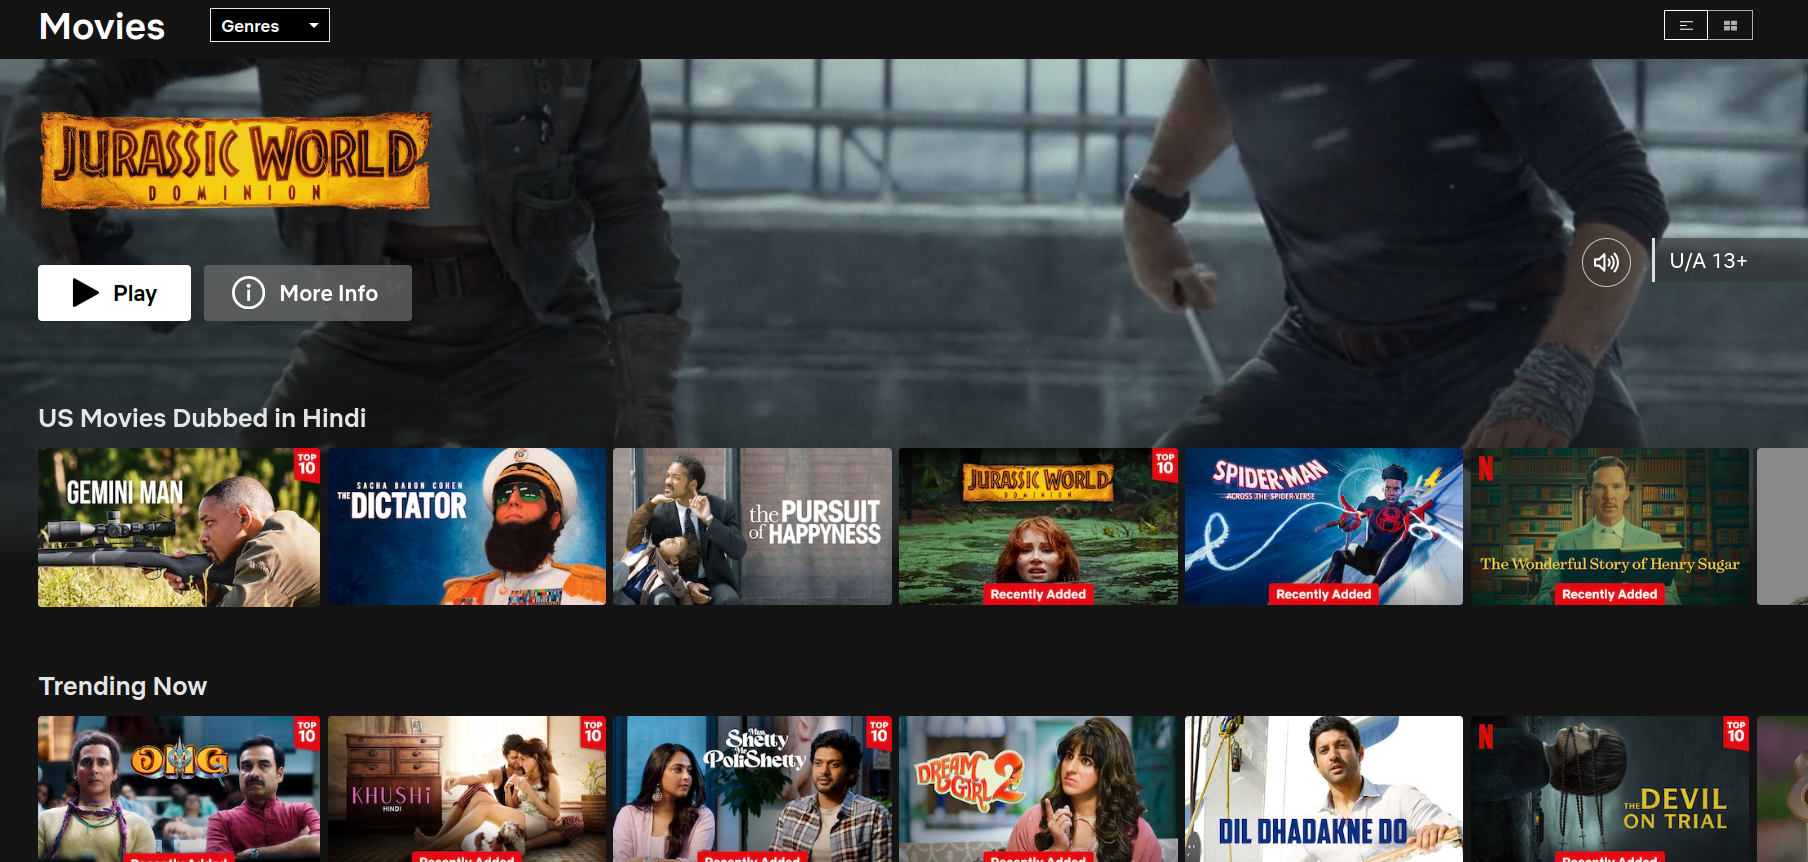

### Collaborative Filtering

Collaborative filtering is a key method used in recommendation systems to predict user preferences based on the preferences of others. It assumes that users with similar past preferences are likely to share similar future preferences. To make accurate predictions, we use `Singular Value Decomposition (SVD)`, a powerful `matrix factorization` technique. For our movie recommender, we’ll use Numpy’s implementation of SVD.

This example demonstrates how to create a **Movie Recommender System** using SVD, a collaborative filtering technique. It utilizes the [MovieLens Latest Small Dataset](https://grouplens.org/datasets/movielens/latest/).

## Let's start by installing and importing the libraries

In [ ]:
# install required libraries
!pip install lancedb pandas

In [ ]:
import lancedb
import numpy as np
import pandas as pd

## Load and unpack the dataset

After unzipping the dataset from MovieLens, we'll load the user ratings into a dataframe `ratings`. Since we don't need timestamp, we can drop that column. We also have to prepare the columns in proper formats.

In [ ]:
# download dataset
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

In [ ]:
# data preprocessing
ratings = pd.read_csv(
    "./ml-latest-small/ratings.csv",
    header=None,
    names=["user id", "movie id", "rating", "timestamp"],
)
ratings = ratings.drop(columns=["timestamp"])
ratings = ratings.drop(0)
ratings["rating"] = ratings["rating"].values.astype(np.float32)
ratings["user id"] = ratings["user id"].values.astype(np.int32)
ratings["movie id"] = ratings["movie id"].values.astype(np.int32)
ratings

,user id,movie id,rating
1,1,1,4.0
2,1,3,4.0
3,1,6,4.0
4,1,47,5.0
5,1,50,5.0
...,...,...,...
100832,610,166534,4.0
100833,610,168248,5.0
100834,610,168250,5.0
100835,610,168252,5.0


We can now create a matrix of user ratings, where each row represents a user and each column represents a movie.

In [ ]:
# pivot table
reviewmatrix = ratings.pivot(
    index="user id", columns="movie id", values="rating"
).fillna(0)
reviewmatrix

movie id,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
user id,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, we apply the **SVD**. `vh` represents the orthogonal matrix that describes the relationship between columns of the original matrix. Because the

---

columns of `vh` correspond to the movies, we can flip it to get the movie embeddings on the rows.

In [ ]:
matrix = reviewmatrix.values
u, s, vh = np.linalg.svd(matrix, full_matrices=False)
vh

array([[-7.0449896e-02, -3.8539346e-02, -1.5912922e-02, ...,
        -6.4683605e-05, -6.4683605e-05, -2.7172931e-04],
       [ 2.7591195e-02,  2.0666271e-03,  2.4714615e-02, ...,
        -5.9758622e-04, -5.9758622e-04, -1.2723620e-03],
       [-7.8443885e-02, -5.6844711e-02, -1.8005114e-02, ...,
         8.7109387e-05,  8.7109387e-05, -1.2283334e-04],
       ...,
       [ 2.0168955e-02,  1.3377998e-02, -1.9083519e-02, ...,
        -1.9121233e-03, -1.9121233e-03, -2.1089672e-03],
       [ 3.5461895e-02, -1.0232525e-01, -1.1956284e-02, ...,
         9.4549108e-04,  9.4549108e-04,  2.5773358e-03],
       [ 6.7939058e-02,  1.2740049e-02, -2.3002084e-02, ...,
        -9.3789837e-05, -9.3789837e-05, -1.9718462e-03]], dtype=float32)

In [ ]:
vectors = np.rot90(np.fliplr(vh))
pd.DataFrame(vectors)

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,-0.070450,0.027591,-0.078444,-0.001684,0.012210,0.032511,-0.064926,0.017924,-0.009497,0.012267,...,0.020612,-0.019381,-0.057998,-0.027171,-0.006926,0.059270,0.110072,0.020169,0.035462,0.067939
1,-0.038539,0.002067,-0.056845,0.050673,0.019879,-0.003510,-0.032134,0.031154,0.027948,0.002091,...,-0.088892,-0.096330,0.050715,0.057505,-0.067907,0.080617,-0.105529,0.013378,-0.102325,0.012740
2,-0.015913,0.024715,-0.018005,0.037453,-0.000156,-0.005317,0.010490,0.004421,-0.026932,0.016773,...,-0.028688,0.002024,0.012164,0.040334,-0.016997,0.041067,-0.002768,-0.019084,-0.011956,-0.023002
3,-0.000871,0.003581,-0.004994,0.001403,0.004760,-0.005955,-0.001583,0.004299,-0.000654,0.000138,...,0.031561,0.031872,0.077064,0.009637,0.001437,-0.003798,-0.015851,-0.007668,-0.007170,0.049587
4,-0.011360,0.011562,-0.024578,0.025911,0.024032,-0.011359,-0.009566,0.010664,-0.010917,0.010871,...,-0.019130,0.018233,0.093399,0.039459,-0.025126,0.031353,0.004618,-0.055738,0.016194,-0.009322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,-0.000074,-0.000683,0.000100,-0.000056,-0.000161,-0.001114,-0.001347,-0.000580,-0.000080,-0.000409,...,-0.001130,0.001340,0.000037,0.000423,0.001391,0.000826,-0.001491,-0.002185,0.001081,-0.000107
9720,-0.000065,-0.000598,0.000087,-0.000049,-0.000141,-0.000975,-0.001179,-0.000507,-0.000070,-0.000357,...,-0.000989,0.001173,0.000032,0.000370,0.001217,0.000722,-0.001305,-0.001912,0.000945,-0.000094
9721,-0.000065,-0.000598,0.000087,-0.000049,-0.000141,-0.000975,-0.001179,-0.000507,-0.000070,-0.000357,...,-0.000989,0.001173,0.000032,0.000370,0.001217,0.000722,-0.001305,-0.001912,0.000945,-0.000094
9722,-0.000065,-0.000598,0.000087,-0.000049,-0.000141,-0.000975,-0.001179,-0.000507,-0.000070,-0.000357,...,-0.000989,0.001173,0.000032,0.000370,0.001217,0.000722,-0.001305,-0.001912,0.000945,-0.000094


Now, let's take the movies dataset to gather the **metadata** for each movie. We'll create an array `data` that contains all this information.

In [ ]:
movies = pd.read_csv(
    "./ml-latest-small/movies.csv", header=0, names=["movie id", "title", "genres"]
)
movies = movies[movies["movie id"].isin(reviewmatrix.columns)]
movies

,movie id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


## Let's see some data

In [ ]:
# prepare data from data ingestion
data = []
for i in range(len(movies)):
    data.append(
        {
            "id": movies.iloc[i]["movie id"],
            "title": movies.iloc[i]["title"],
            "vector": vectors[i],
            "genre": movies.iloc[i]["genres"],
        }
    )
pd.DataFrame(data)

,id,title,vector,genre
0,1,Toy Story (1995),"[-0.070449896, 0.027591195, -0.078443885, -0.0...",Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),"[-0.038539346, 0.0020666271, -0.05684471, 0.05...",Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),"[-0.015912922, 0.024714615, -0.018005114, 0.03...",Comedy|Romance
3,4,Waiting to Exhale (1995),"[-0.00087145035, 0.0035811856, -0.0049938704, ...",Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),"[-0.011360065, 0.011561904, -0.024578463, 0.02...",Comedy
...,...,...,...,...
9719,193581,Black Butler: Book of the Atlantic (2017),"[-7.392412e-05, -0.0006829557, 9.955359e-05, -...",Action|Animation|Comedy|Fantasy
9720,193583,No Game No Life: Zero (2017),"[-6.4683605e-05, -0.0005975862, 8.710939e-05, ...",Animation|Comedy|Fantasy
9721,193585,Flint (2017),"[-6.4683605e-05, -0.0005975862, 8.710939e-05, ...",Drama
9722,193587,Bungo Stray Dogs: Dead Apple (2018),"[-6.4683605e-05, -0.0005975862, 8.710939e-05, ...",Action|Animation


## Connect to LanceDB
We can now connect a path to LanceDB, which stores our vector database. We'll also create a new table `movie_set` with the data we just created.

In [ ]:
# create lancedb table
db = lancedb.connect("./data/test-db")
try:
    table = db.create_table("movie_set", data=data)
except:
    table = db.open_table("movie_set")

## Get the Recommendations
Finally, we can create a function that takes a movie title and returns the top 5 similar movies. By searching in our vector store for the embeddings of the movie, we can return a dataframe of the most similar movies. We can also add some flair reading and displaying the links of each movie.

In [ ]:
# helper function for recommendations
def get_recommendations(title):
    pd_data = pd.DataFrame(data)
    result = (
        table.search(pd_data[pd_data["title"] == title]["vector"].values[0])
        .limit(5)
        .to_pandas()
    )

    links = pd.read_csv(
        "./ml-latest-small/links.csv",
        header=0,
        names=["movie id", "imdb id", "tmdb id"],
        converters={"imdb id": str},
    )

    ret = result["title"].values.tolist()
    for i in range(len(ret)):
        link = links[links["movie id"] == result["id"].values[i]]["imdb id"].values[0]
        link = "https://www.imdb.com/title/tt" + link
        ret[i] = [ret[i], link]
    return ret

## Let's test it out!

In [ ]:
get_recommendations("Moana (2016)")

[['Moana (2016)', 'https://www.imdb.com/title/tt3521164'],
 ['The Boss Baby (2017)', 'https://www.imdb.com/title/tt3874544'],
 ['The Book of Life (2014)', 'https://www.imdb.com/title/tt2262227'],
 ['Kubo and the Two Strings (2016)', 'https://www.imdb.com/title/tt4302938'],
 ['Bad Moms (2016)', 'https://www.imdb.com/title/tt4651520']]

In [ ]:
get_recommendations("Rogue One: A Star Wars Story (2016)")

[['Rogue One: A Star Wars Story (2016)',
  'https://www.imdb.com/title/tt3748528'],
 ['Wonder Woman (2017)', 'https://www.imdb.com/title/tt0451279'],
 ['Miss Sloane (2016)', 'https://www.imdb.com/title/tt4540710'],
 ['Passengers (2016)', 'https://www.imdb.com/title/tt1355644'],
 ['Man of Steel (2013)', 'https://www.imdb.com/title/tt0770828']]

## Get Recommendation for Movie of your Choice

In [ ]:
movie_name = ""
get_recommendations(movie_name)

## Tada!! your first movie recommendation system is live

Of course, this won't be completely accurate. There are other ways improve the accuracy, such as `reducing the dimensions` of the original data, or filtering out users/movies with few ratings. But this is a good start to building a movie recommender system.